# Clustering the whole dataset

In this step you should load the saved autoencoder and the embeddings, reduce the dimension of embeddings and apply some clustering (kmeans, hbdscan) to identify the clusters.
Then you should save the cluster information (index of points in each cluster) to be used for analysis. 

The goal here is to identify broad topics that exist in our dataset

In [1]:
import torch
from utils.autoencoders import LinearAutoEncoder

# same deal
from utils.embeddings import get_sbert_embeddings
from pathlib import Path
DATA_DIR = Path('/data/blockchain-interoperability/blockchain-social-media/twitter-data/kmeans_clusters')

embeddings = get_sbert_embeddings(
    snapshot_path = DATA_DIR/'snapshots',
    embeddings_path = DATA_DIR/'embeddings',
)



# and the model
autoenc = LinearAutoEncoder()
autoenc.load_state_dict(torch.load(DATA_DIR/'autoenc_10_epoch.pkl'))
# freeze the model, because we don't want to do any more calculations. This saves computational power
autoenc.requires_grad = False

loading from cache


In [2]:
# example of using the encoder
reduced_embs = autoenc.encoder(embeddings)

And here the clustering starts...

In [17]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import time

size = 1000000
model = autoenc.cuda()

#find elbow using inertia and distortion
#use minibatch for optimal k computation to speed up calculations
cluster_count = range(2, 21)
batched_elbows = [0]*len(cluster_count)
km_multiple = [KMeans(n_clusters=i, max_iter=100, n_init='auto') for i in cluster_count]

In [18]:
it_count = 0
for i in range(len(reduced_embs)):
  it_count+=1
  start = time.perf_counter()

  batch = reduced_embs[i*size:(i+1)*size]
  if len(batch) == 0:
    break
  
  fits = [i.fit(batch.detach().numpy()) for i in km_multiple]
  inertias = [i.inertia_ for i in fits]
  batched_elbows = [a+b for a, b in zip(inertias, batched_elbows)]

  print("Iteration", it_count, f"Time taken:  {time.perf_counter()-start} seconds")
  #jsquared errors for evaluating internal consistency in clusters

Iteration 1 Time taken:  28.062742799520493 seconds
Iteration 2 Time taken:  28.7414845880121 seconds
Iteration 3 Time taken:  27.90094338916242 seconds
Iteration 4 Time taken:  27.922110449522734 seconds
Iteration 5 Time taken:  29.423199759796262 seconds
Iteration 6 Time taken:  27.761278254911304 seconds
Iteration 7 Time taken:  29.3836408611387 seconds
Iteration 8 Time taken:  28.14368843752891 seconds
Iteration 9 Time taken:  26.21903150714934 seconds
Iteration 10 Time taken:  27.169281143695116 seconds
Iteration 11 Time taken:  27.613666931167245 seconds
Iteration 12 Time taken:  29.23313334584236 seconds
Iteration 13 Time taken:  28.904695285484195 seconds
Iteration 14 Time taken:  25.010256574489176 seconds
Iteration 15 Time taken:  24.679160826839507 seconds


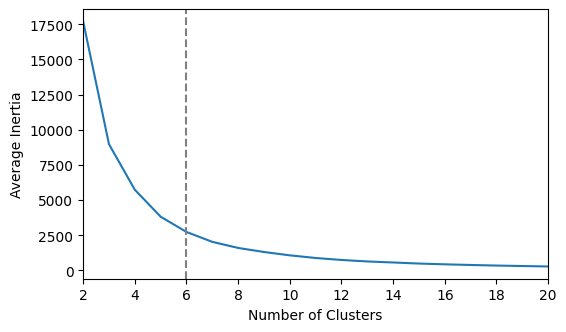

In [20]:
from kneed import KneeLocator
knee_loc = KneeLocator(range(2, 21), batched_elbows, curve="convex", direction="decreasing")
knee_loc.elbow

import matplotlib.pyplot as plt

results = [x/it_count for x in batched_elbows]
plt.figure(figsize=(6, 3.5))
plt.plot(cluster_count, results)
plt.xlim(2, 20)
#plt.title("Elbow Plot for Optimal K Discovery")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Inertia")
plt.axvline(x=knee_loc.elbow, color="grey", linestyle='--')
#plt.show()
plt.savefig('kmeans_elbow.pdf')
#plt.savefig('../../data/blockchain-interoperability/blockchain-social-media/twitter-data/kmeans_elbow.pdf')

In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=knee_loc.elbow, n_init='auto').fit(reduced_embs.detach().numpy())
kmeans.labels_

array([2, 4, 2, ..., 4, 0, 4], dtype=int32)

In [12]:
import numpy as np

indices={}
for i in range(knee_loc.elbow):
    index_i = np.where(kmeans.labels_==i)[0]
    indices[i] = index_i.tolist()
    print(len(index_i))

5478862
1118990
2543961
160048
5075115
596521


In [13]:
import json
with open('kmeans_init_clusters.json', 'w') as f:
    json.dump(indices, f)

Once the clusters are chosen, look inside the contents of each cluster

In [3]:
import pandas as pd

# loads a pd.Series object that can be accessed by the indexes found in clusters
whole_text = pd.read_pickle('../..'/DATA_DIR/'snapshots/whole_text.pkl')

Load cluster indexes from json file

In [4]:
import json

f = open('kmeans_init_clusters.json')
idx_df = json.load(f)

In [5]:
keys = list(idx_df.keys())
for i in range(6):
    print("Cluster", i, "Tweet Subset")
    clusteri_df = whole_text.iloc[idx_df[keys[i]]]
    print(clusteri_df.head())

Cluster 0 Tweet Subset
5     token Status!? still going?? $APTOS @hanrris98...
8     To the moo!n 🌙 @JanGilissen1 @Shubhu_tweets07 ...
9     @kriptojoker1 @KenanOrdulu4 I Wish I discovere...
12    Hacking is easy,\nDm to Recover or Hack accoun...
16    Have you hezard about Layer Zero guys? @Endisn...
Name: whole_text, dtype: object
Cluster 1 Tweet Subset
26    I never want to hear shit about "transparency"...
57    #IF THE RUSSIANS DESTROYED THE BRIDGE THERE'S ...
67    Crypto Gorilla sent me @nainteres @IncertiMarc...
72    VERY VERY STRONG PROJECT 🥰🥰🥰🥰🥰🥰🥰🥰🥰❤️❤️❤️❤️❤️❤️...
89    JNU Seeks Security Report On Clash Between 2 G...
Name: whole_text, dtype: object
Cluster 2 Tweet Subset
0     @0x5ab0 @Uniswap oh, missed fiat part, just sa...
2     @abu_crypto1 🩸 Scary bunny is a meme token wit...
6     I really need to learn how to dev on blockchai...
10    @FraserNelson Of course it's not the elephant ...
18    Fondateur de @coinalist / Crypto World since 2...
Name: whole_text, dtype: ob

In [13]:
import preprocessor as p
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords
#nltk.download
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

#forming a separate feature for cleaned tweets
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer =  TweetTokenizer()
stop_words = set(stopwords.words('english'))
cleaned_dict = {}
for i in range(6):
    clusteri_df = whole_text.iloc[idx_df[keys[i]]]
    clusteri_df = clusteri_df.to_frame()
    text = clusteri_df['whole_text']
    cleaned_text = []
    for j in text:
        cleaned = p.clean(j)
        cleaned = cleaned.replace('\d+', '')
        
        lower_text = cleaned.lower()
        no_punct = re.sub(f"[{re.escape(punctuation)}]", "", lower_text)  # Remove punctuation
        text = " ".join(no_punct.split())  # Remove extra spaces, tabs, and new lines
        lems = [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]
        lems = " ".join(lems)
        #remove single characters
        cleaned_text.append(re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', lems))
    cleaned_dict[str(i)] = cleaned_text

In [17]:
import json
with open('kmeans_cleaned_text.json', 'w') as f:
    json.dump(cleaned_dict, f)

In [3]:
import json

f = open('kmeans_cleaned_text.json')
cleaned_dict = json.load(f)

In [22]:
from collections import Counter

for i in cleaned_dict.keys():
    spam = []
    c = Counter(cleaned_dict[i])
    for j in c.keys():
        if j.find('200k') != -1:
            print(c[j], i)
        if c[j] > 1000:
            spam.append(j)
    print(len(spam))

340815 0
1 0
3 0
623666 0
1 0
1 0
68 0
112 0
3 0
1 0
1 0
1 0
1 0
1369 0
1 0
1 0
1 0
1 0
22 0
1 0
1 0
1 0
1 0
17500 0
54725 0
1 0
1 0
4 0
2 0
5 0
1 0
1 0
1 0
6 0
6 0
1 0
2 0
5 0
2 0
1 0
5 0
9 0
1 0
3 0
1 0
1 0
1 0
1 0
1 0
1 0
9 0
6 0
1 0
2 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
2 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
4 0
1 0
2 0
3 0
2 0
2 0
4 0
2 0
2 0
1 0
3 0
3 0
2 0
3 0
2 0
2 0
9 0
1 0
3 0
7 0
6 0
3 0
2 0
2 0
2 0
2 0
2 0
3 0
6 0
4 0
7 0
2 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
4 0
2 0
2 0
3 0
1 0
2 0
2 0
1 0
5 0
3 0
2 0
2 0
1 0
2 0
1 0
1 0
8 0
3 0
4 0
4 0
3 0
5 0
4 0
4 0
14 0
3 0
1 0
5 0
1 0
3 0
5 0
4 0
1 0
1 0
1 0
3 0
2 0
1 0
1 0
1 0
2 0
2 0
2 0
12 0
2 0
1 0
1 0
4 0
1 0
1 0
2 0
1 0
2 0
2 0
2 0
1 0
3 0
1 0
3 0
3 0
1 0
7 0
1 0
1 0
1 0
1 0
2 0
1 0
2 0
1 0
1 0
2 0
1 0
2 0
1 0
1 0
3 0
3 0
3 0
1 0
1 0
3 0
1 0
2 0
3 0
1 0
1 0
8 0
2 0
3 0
1 0
3 0
1 0
1 0
12 0
2 0
1 0
2 0
1 0
1 0
5 0
1 0
1 0
1 0
1 0
1 0
1 0
2 0
1 0
1 0
5747 0
1 0
1 0
1 0
1 0
1 0
2 0
1 0
2 0
2 0
2 0
1 0
1 0
1 0
2 0
2 0
1

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
tok_vectorizer = CountVectorizer(max_features=100, stop_words='english')
token_dict = {}
for i in cleaned_dict.keys():
    cleaned_text = list(set(cleaned_dict[i]))
    #print((1-(len(cleaned_text)/len(cleaned_dict[i])))*100, (len(cleaned_dict[i])-len(cleaned_text))/len(cleaned_dict[i]))
    X = tfidf_vectorizer.fit_transform(cleaned_text)
    tokens = tfidf_vectorizer.get_feature_names_out()
    #print(tokens)
    #print(X[:,0])
    feature_array = np.array(tokens)
    tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]

    n = 100
    top_n = feature_array[tfidf_sorting][:n]
    print(top_n)
    token_dict[i] = [tokens.tolist(), top_n.tolist()]
    #result = pd.DataFrame(data=X.toarray(), columns=tokens)
    #print(result)
    
    #tfidf_matrix = pd.DataFrame(data=X.toarray(),columns=tokens)
    #print("Cluster", i, "TF-IDF Matrix\n", tfidf_matrix)
    print("*************************")

    del tokens, cleaned_text, X

['free' 'youre' 'great' 'event' 'exchange' 'ftx' 'fund' 'future' 'game'
 'going' 'good' 'got' 'group' 'year' 'guy' 'ha' 'hack' 'happen' 'help'
 'id' 'im' 'job' 'join' 'just' 'dont' 'doesnt' 'doe' 'didnt' 'airdrop'
 'amp' 'asset' 'bad' 'bank' 'best' 'better' 'big' 'binance' 'bitcoin'
 'blockchain' 'bridge' 'buy' 'check' 'coin' 'come' 'community' 'company'
 'crypto' 'day' 'did' 'know' 'let' 'life' 'security' 'social' 'space'
 'support' 'team' 'thats' 'thing' 'think' 'time' 'today' 'token' 'twitter'
 'use' 'user' 'wa' 'wallet' 'want' 'way' 'week' 'whale' 'work' 'world'
 'signal' 'say' 'like' 'roll' 'long' 'look' 'lot' 'love' 'make' 'market'
 'money' 'national' 'need' 'new' 'news' 'nft' 'people' 'place' 'platform'
 'price' 'project' 'pump' 'real' 'really' 'right' 'account']
*************************
['binance' 'year' 'insight' 'ftx' 'future' 'going' 'good' 'got' 'guy' 'ha'
 'hack' 'hour' 'im' 'just' 'eth' 'know' 'let' 'like' 'line' 'liquid'
 'long' 'look' 'love' 'ma200' 'exchange' 'dont' '

In [14]:
import json
with open('tfidf_keytokens.json', 'w') as f:
    json.dump(token_dict, f)